In [ ]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization,Dropout
from sklearn.preprocessing import StandardScaler

2025-03-10 11:17:09.749367: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


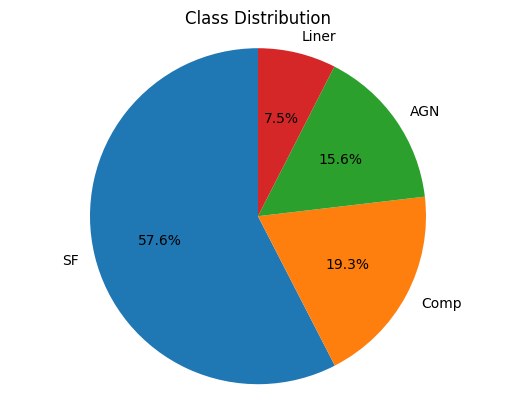

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sizes = [len(ind_sf_train)+len(ind_sf_test), len(ind_comp_train) + len(ind_comp_test), len(ind_AGN_train) + len(ind_AGN_test), len(ind_liner_train)+ len(ind_liner_test)]
labels = ['SF', 'Comp', 'AGN', 'Liner']

#colors
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Class Distribution')
plt.show()


In [6]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train_split = scaler.transform(X_train_split)

X_val_split = scaler.transform(X_val_split)
X_test = scaler.transform(X_test)


model = Sequential()
model.add(Dense(128,name="fc1", input_shape=(8,), kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Activation(activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Dense(512, name="fc2", kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Activation(activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Dense(521,name="fc3", kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Activation(activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

model.summary(show_trainable=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ fc1 (Dense)                 │ (None, 128)           │      1,152 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation (Activation)     │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization         │ (None, 128)           │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ fc2 (Dense)                 │ (None, 512)           │     66,048 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_1 (Activation)   │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_1       │ (None, 512)           │      2,048 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ fc3 (Dense)                 │ (None, 521)           │    267,273 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_2 (Activation)   │ (None, 521)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_2       │ (None, 521)           │      2,084 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 521)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 4)             │      2,088 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 341,205 (1.30 MB)

 Trainable params: 338,883 (1.29 MB)

 Non-trainable params: 2,322 (9.07 KB)

In [7]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

model_history = model.fit(X_train_split, y_train_split, epochs=20, batch_size=64, verbose=1, shuffle=True, validation_data=(X_val_split, y_val_split))

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6518 - loss: 8.1410 - val_accuracy: 0.7536 - val_loss: 7.1509
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8219 - loss: 6.4893 - val_accuracy: 0.7591 - val_loss: 5.8685
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8335 - loss: 5.4000 - val_accuracy: 0.7790 - val_loss: 4.9088
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8444 - loss: 4.4948 - val_accuracy: 0.7724 - val_loss: 4.1153
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8443 - loss: 3.8105 - val_accuracy: 0.8265 - val_loss: 3.4266
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8356 - loss: 3.2699 - val_accuracy: 0.8243 - val_loss: 2.9033
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8424 - loss: 2.8000 - val_accuracy: 0.8431 - val_loss: 2.4926
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8438 - loss: 2.4039 - val_accuracy: 0.8398 - v

In [8]:
pred = model.predict(X_test,verbose=0)

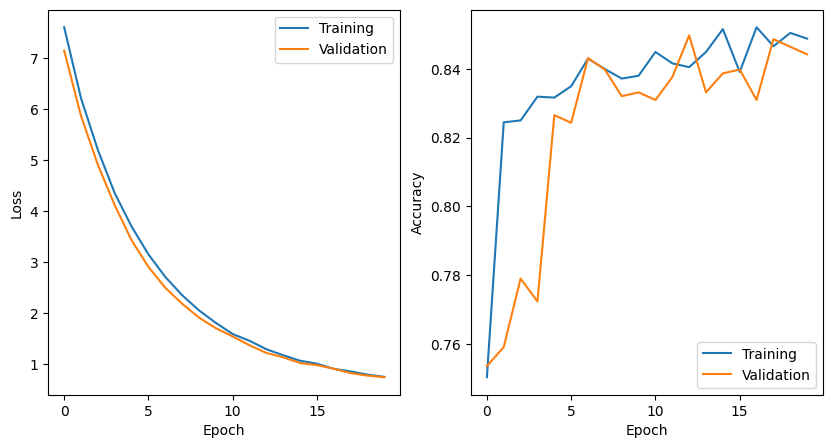

In [9]:
from plotting import plot_model_history

plot_model_history(model_history)

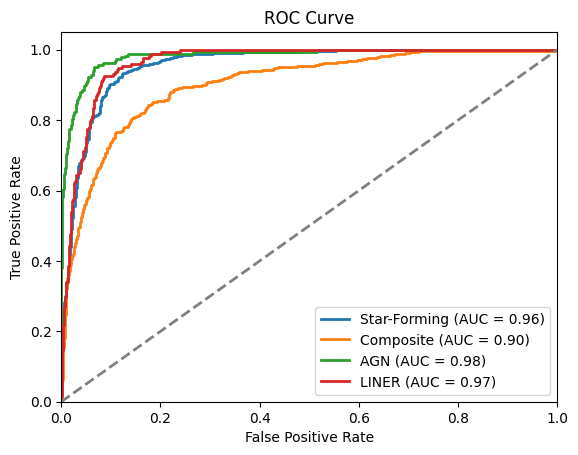

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_prob = pred

fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()

classes = ['Star-Forming', 'Composite', 'AGN', 'LINER']

for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.legend(loc='lower right')
plt.show()


# Intermediate Redshift Galaxies (0.32<z<0.8)

We now test our trained model on the intermediate redshift galaxy dataset to see how it performs.

In [ ]:

#open intermediate redshift file

import pickle
import kcorrect
from kcorrect import fitter  # Assuming 'fitter' is still part of the kcorrect module

def preprocess_data(input_file):
    # Read data
    data = Table.read(input_file, header_start=0, data_start=1)

    print("mag_g values <= 0:", np.sum(data['mag_g'] <= 0))
    print("mag_r values <= 0:", np.sum(data['mag_r'] <= 0))
    print("mag_i values <= 0:", np.sum(data['mag_i'] <= 0))
    print("mag_z values <= 0:", np.sum(data['mag_z'] <= 0))

    # More selection based on new magnitudes
    valid_indices = np.where(
        (data['o3'] > 0) & (data['o21'] > 0) & (data['o22'] > 0) & (data['hb'] > 0) &
        (data['ha'] > 0) & (data['s21'] > 0) & (data['s22'] > 0) & (data['sigma_o3'] > 0) &
        (data['sigma_o3_err'] > 0) & (data['VDISP'] > 0) & (data['mag_u'] > 0) &
        (data['flux_g'] > 0) & (data['flux_r'] > 0) & (data['flux_z'] > 0)
    )

    valid_indices = np.where(
        (10 < data['mag_g']) & (data['mag_g'] < 40) &
        (5 < data['mag_r']) & (data['mag_r'] < 40) &
        (5 < data['mag_z']) & (data['mag_z'] < 40)
    )[0]

    print(len(valid_indices))


    if len(valid_indices) == 0:
        raise ValueError("No valid sources found after filtering.")

    # Convert magnitudes to maggies
    maggies = np.vstack([
        10 ** ((22.5 - data[f'mag_{band}'][valid_indices]) / 2.5)
        for band in ['u', 'g', 'r', 'i', 'z']
    ]).T

    # Redshift array
    z_arr = np.array(data['z'][valid_indices])

    # Apply k-correction using `fitter.fit` instead of `fit_nonneg`
    # Assuming that the 'fit' function exists and is compatible
    coeffs = fitter.fit(z_arr, maggies)  # Use fitter.fit instead of fitter.fit_nonneg
    maggies_corrected = fitter.reconstruct_maggies(coeffs)

    # Convert back to magnitudes
    mags_corrected = 22.5 - 2.5 * np.log10(maggies_corrected.clip(min=0.001))

    # Compute features
    O2_index = np.log10((data['o21'][valid_indices] + data['o22'][valid_indices]) / data['hb'][valid_indices])
    O3_index = np.log10(data['o3'][valid_indices] / data['hb'][valid_indices])
    sigma_o3 = np.log10(np.sqrt(data['sigma_o3'][valid_indices] ** 2))
    sigma_star = np.log10(data['VDISP'][valid_indices])
    sigma_star[sigma_star == 0] = 10.0

    # Colors
    u_g, g_r, r_i, i_z = np.diff(mags_corrected, axis=1).T

    # Handle NaNs/Infs
    for arr in [O3_index, O2_index, sigma_star, sigma_o3, u_g, g_r, r_i, i_z]:
        arr[np.isinf(arr)] = 0
        arr = np.nan_to_num(arr)

    # Final feature matrix
    X_test = np.column_stack([O3_index, O2_index, sigma_star, sigma_o3, u_g, g_r, r_i, i_z])

    return X_test



X_test = preprocess_data('data_elg.csv')

pred = model.predict(X_test,verbose=0)


In [71]:
X_test = preprocess_data('data_elg.csv')

pred = model.predict(X_test,verbose=0)

mag_g values <= 0: 33
mag_r values <= 0: 33
mag_i values <= 0: 33
mag_z values <= 0: 33
1464


AttributeError: module 'kcorrect.fitter' has no attribute 'fit'